# Przetwarzanie wstępne. Filtracja kontekstowa.


### Cel:
- zapoznanie z pojęciem kontekstu / filtracji kontekstowej,
- zapoznanie z pojęciem konwolucji (splotu),
- zapoznanie z wybranymi filtrami:
	- filtry liniowe dolnoprzepustowe:
		- filtr uśredniający,
		- filtr Gaussa.
	- filtry nielinowe:
		- mediana,
		- mediana dla obrazów kolorowych.
	- filtry liniowe górnoprzepustowe:
			- laplasjan,
			- operator Robersta, Prewitta, Sobela.
- zadanie domowe: adaptacyjna filtracja medianowa.

### Filtry liniowe uśredniające (dolnoprzepustowe)

Jest to podstawowa rodzina filtrów stosowana w cyfrowym przetwarzaniu obrazów. 
Wykorzystuje się je w celu "rozmazania" obrazu i tym samym redukcji szumów (zakłóceń) na obrazie.
Filtr określony jest przez dwa parametry: rozmiar maski (ang. _kernel_) oraz wartości współczynników maski.

Warto zwrócić uwagę, że omawiane w niniejszym rozdziale operacje generują nową wartość piksela na podstawie pewnego fragmentu obrazu (tj. kontekstu), a nie jak operacje punktowe tylko na podstawie jednego piksela.


1. Wczytaj obraz _plansza.png_.
W dalszej części ćwiczenia sprawdzenie działania filtracji dla innych obrazów sprowadzi się do wczytania innego pliku.

2. Podstawowa funkcja to `cv2.filter2D`  - realizacja filtracji konwolucyjnej.
   Proszę sprawdzić jej dokumentację i zwrócić uwagę na obsługę problemu brzegowego (na krawędziach istnieją piksele dla których nie da się wyznaczyć otoczenia).

  Uwaga. Problem ten można też rozwiązać z użyciem funkcji `signal.convolve2d` z biblioteki _scipy_ (`from scipy import signal`).

3. Stwórz podstawowy filtr uśredniający o rozmiarze $3 \times 3$ -- za pomocą funkcji `np.ones`. Wykonaj konwolucję na wczytanym obrazie. Na wspólnym rysunku wyświetl obraz oryginalny, po filtracji oraz moduł z różnicy.

4. Przeanalizuj otrzymane wyniki. Jakie elementy zawiera obraz "moduł z różnicy"? Co na tej podstawie można powiedzieć o filtracji dolnoprzepustowej?

In [20]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/06_Context/'

fileNames = ["jet.png", "kw.png", "moon.png", "lenaSzum.png", "lena.png", "plansza.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)



5. Na wspólnym rysunku wyświetl wyniki filtracji uśredniającej z oknem o rozmiarze 3, 5, 9, 15 i 35. 
Wykorzystaj polecenie `plt.subplot`. 
Przeanalizuj wpływ rozmiaru maski na wynik. 

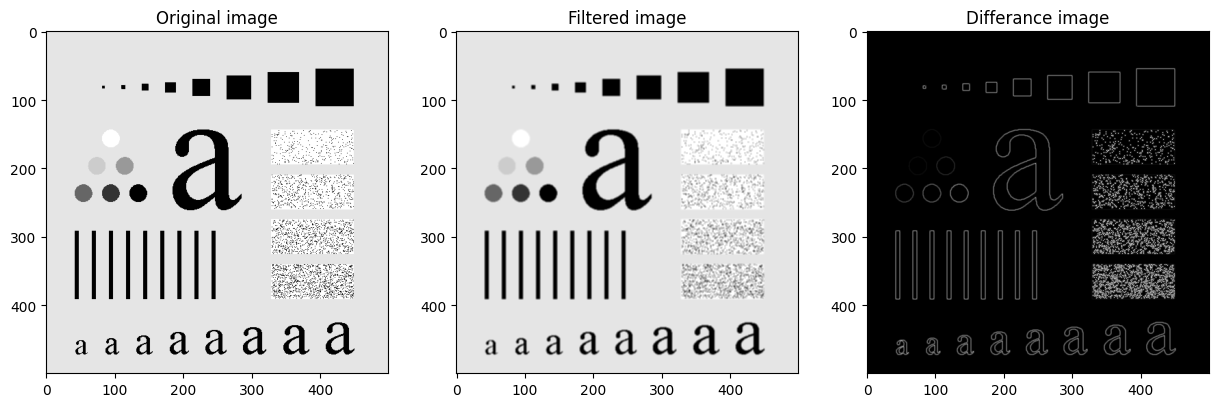

In [128]:
def read_img(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

board_img = read_img('plansza.png')



def apply_kernel(img, size):
    kernel = np.ones((size, size), dtype=np.float32) 
    kernel /= (size*size)
    return cv2.filter2D(src=img, ddepth=-1, kernel=kernel, borderType=cv2.BORDER_REPLICATE)


def plot_images(original_img, result_img, diff_img=None, title=None):
    n_cols = 3 if diff_img is not None else 2
    fig, ax = plt.subplots(1, n_cols, figsize=(5*n_cols, 5)) 
    
   
    
    ax[0].imshow(original_img, cmap='gray')
    ax[1].imshow(result_img, cmap='gray')
    ax[0].set_title('Original image')
    ax[1].set_title('Filtered image')
    if diff_img is not None:
        ax[2].imshow(diff_img, cmap='gray')
        ax[2].set_title('Differance image')
        
    if title:
        fig.suptitle(title, fontsize=16)
    plt.show()
    
    
filtered_board = apply_kernel(board_img, size=3)
differ_img = cv2.absdiff(filtered_board, board_img)
plot_images(original_img=board_img, result_img=filtered_board, diff_img=differ_img)



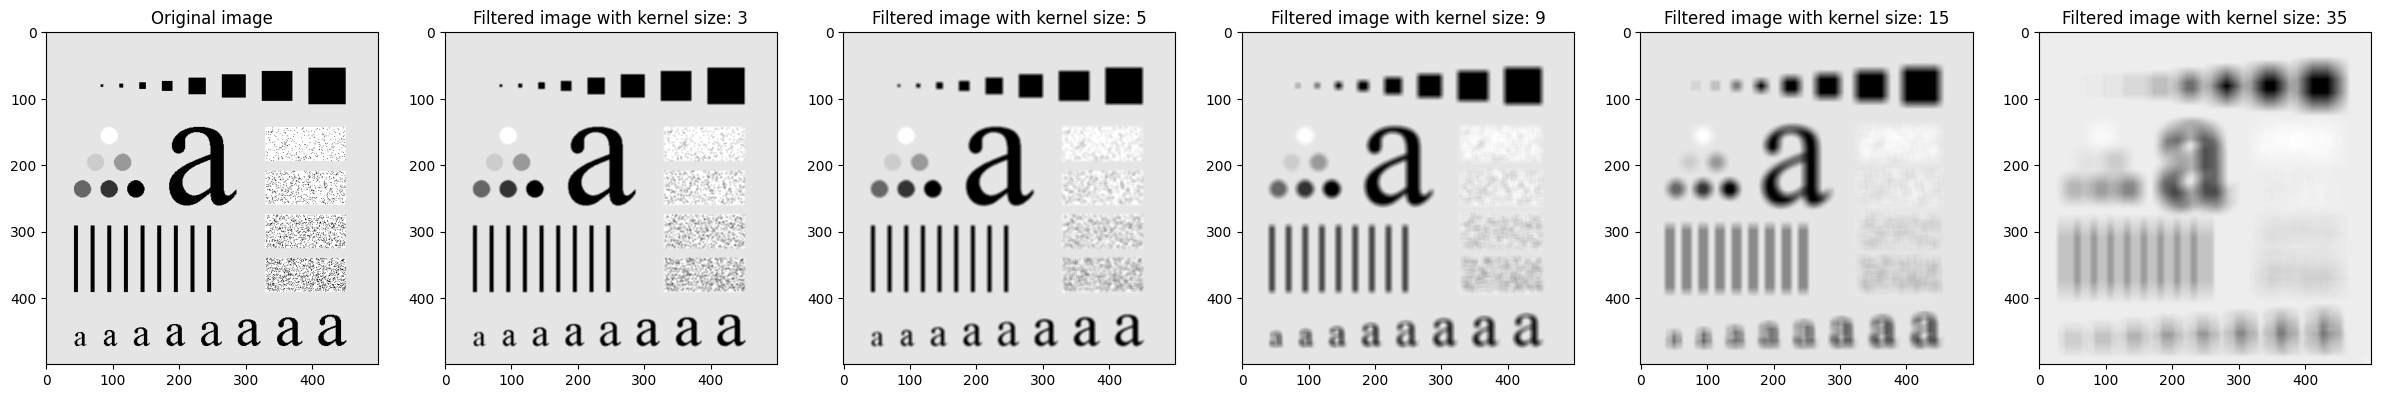

In [44]:
def plot_averaging(image: np.ndarray, sizes:list[int]):
    n = len(sizes)+1
    fig, axes = plt.subplots(1, n, figsize=(n*5, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original image")
    
    for i in range(1, n):
        axes[i].imshow(apply_kernel(image, sizes[i-1]),cmap='gray')
        axes[i].set_title(f"Filtered image with kernel size: {sizes[i-1]}")
        
    plt.show()
        
    
    
plot_averaging(board_img, sizes=[3, 5, 9, 15, 35])
    

6. Wczytaj obraz _lena.png_.
Zaobserwuj efekty filtracji dolnoprzepustowej dla obrazu rzeczywistego.

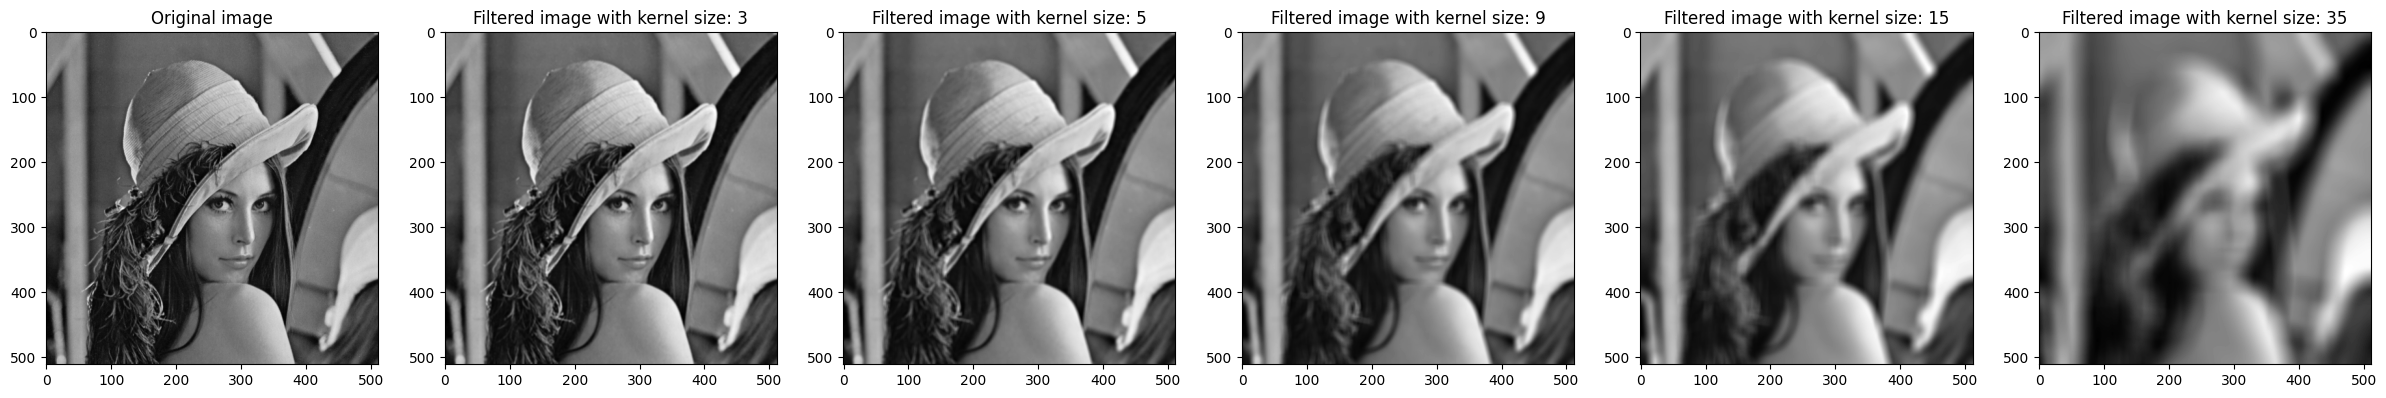

In [48]:
lena_img = read_img('lena.png')
plot_averaging(lena_img, sizes=[3, 5, 9, 15, 35])


7. Niekorzystny efekt towarzyszący wykonanym filtracjom dolnoprzepustowym to utrata ostrości. 
Częściowo można go zniwelować poprzez odpowiedni dobór maski. 
Wykorzystaj maskę:  `M = np.array([1 2 1; 2 4 2; 1 2 1])`. 
Przed obliczeniami należy jeszcze wykonać normalizację - podzielić każdy element maski przez sumę wszystkich elementów: `M = M/sum(sum(M));`.
Tak przygotowaną maskę wykorzystaj w konwolucji - wyświetl wyniki tak jak wcześniej.
Możliwe jest też wykorzystywanie innych masek - współczynniki można dopasowywać do konkretnego problemu.

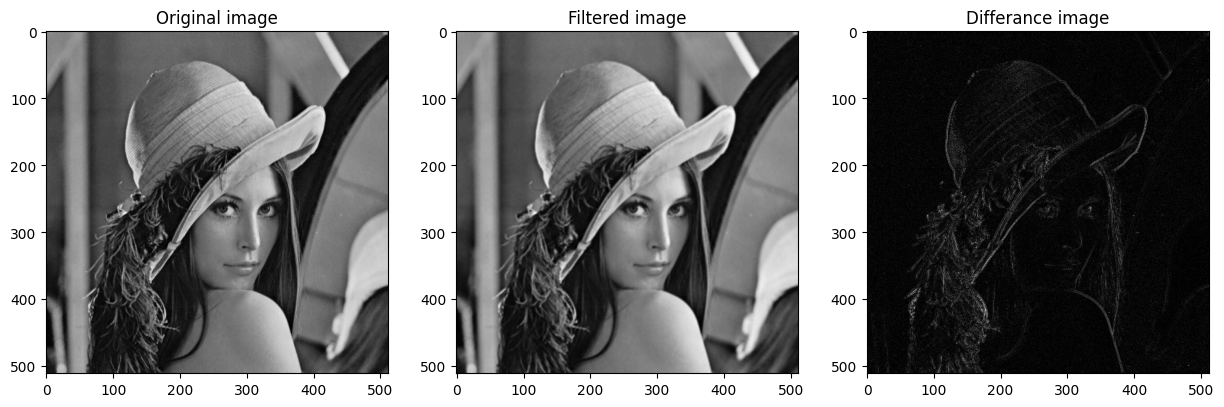

In [54]:
M = np.array([
    [1 ,2, 1],
    [2, 4, 2],
    [1, 2, 1]
])
M = M/sum(sum(M))

filtered_lena = cv2.filter2D(src=lena_img, ddepth=-1, kernel=M)
differ_lena =  cv2.absdiff(filtered_lena , lena_img)


plot_images(original_img=lena_img, result_img=filtered_lena, diff_img=differ_lena)

8. Skuteczną i często wykorzystywaną maską jest tzw. maska Gasussa.
Jest to zbiór liczb, które aproksymują dwuwymiarowy rozkład Gaussa. 
Parametrem jest odchylenie standardowe i rozmiar maski.

9. Wykorzystując przygotowaną funkcję `fgaussian` stwórz maskę o rozmiarze $5 \times 5$ i odchyleniu standardowym 0.5.
  Wykorzystując funkcję `mesh` zwizualizuj filtr.
  Sprawdź jak parametr ``odchylenie standardowe'' wpływa na ``kształt'' filtru.

  Uwaga. W OpenCV dostępna jest *dedykowana* funkcja do filtracji Gaussa - `GaussianBlur`.
  Proszę na jednym przykładzie porównać jej działanie z użytym wyżej rozwiązaniem.

10. Wykonaj filtrację dla wybranych (2--3) wartości odchylenia standardowego.


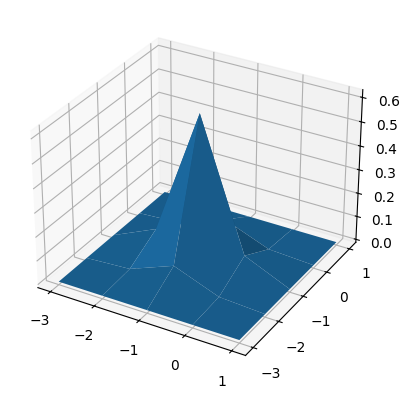

In [57]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 
    
    
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    
    plt.show()
    
mask = fgaussian(size=5, sigma=0.5)
mesh(mask, 5)
    



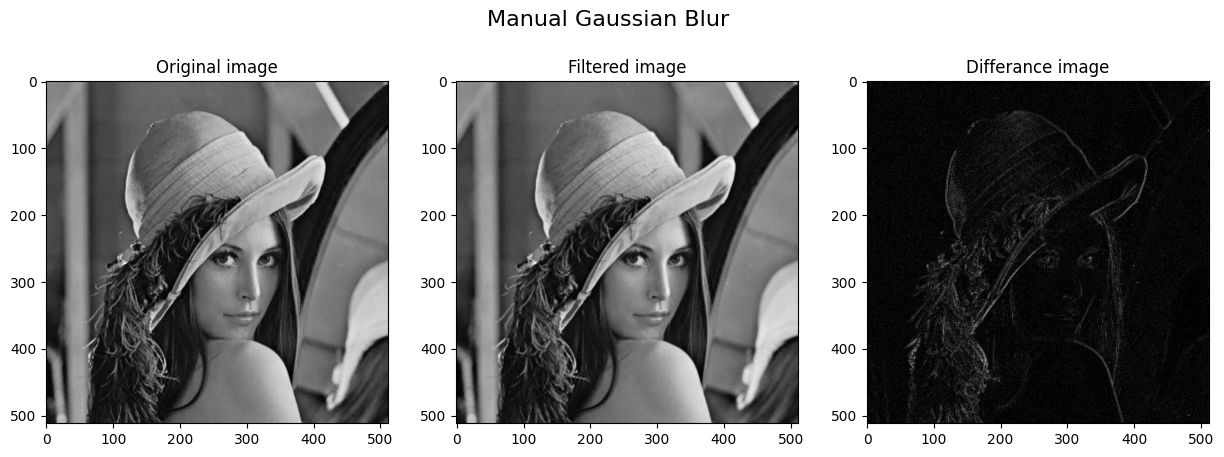

In [76]:
filtered_lena = cv2.filter2D(src=lena_img, ddepth=-1, kernel=fgaussian(size=5, sigma=0.5))
differ_lena = cv2.absdiff(lena_img, filtered_lena)

plot_images(original_img=lena_img, result_img=filtered_lena, diff_img=differ_lena, title='Manual Gaussian Blur')


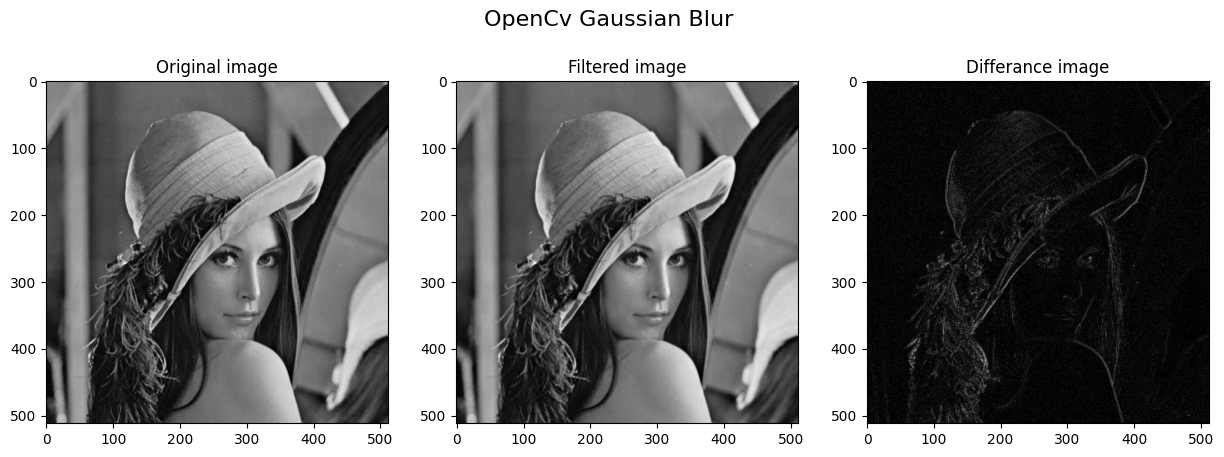

In [75]:
filtered_lena = cv2.GaussianBlur(src=lena_img, ksize=(5, 5), sigmaX=0.5)
differ_lena = cv2.absdiff(lena_img, filtered_lena)

plot_images(original_img=lena_img, result_img=filtered_lena, diff_img=differ_lena, title='OpenCv Gaussian Blur')

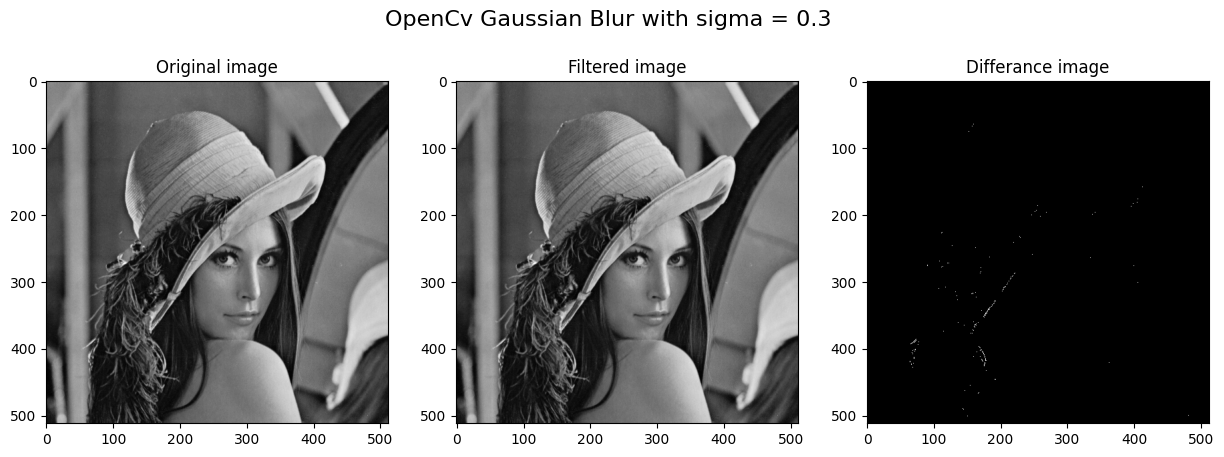

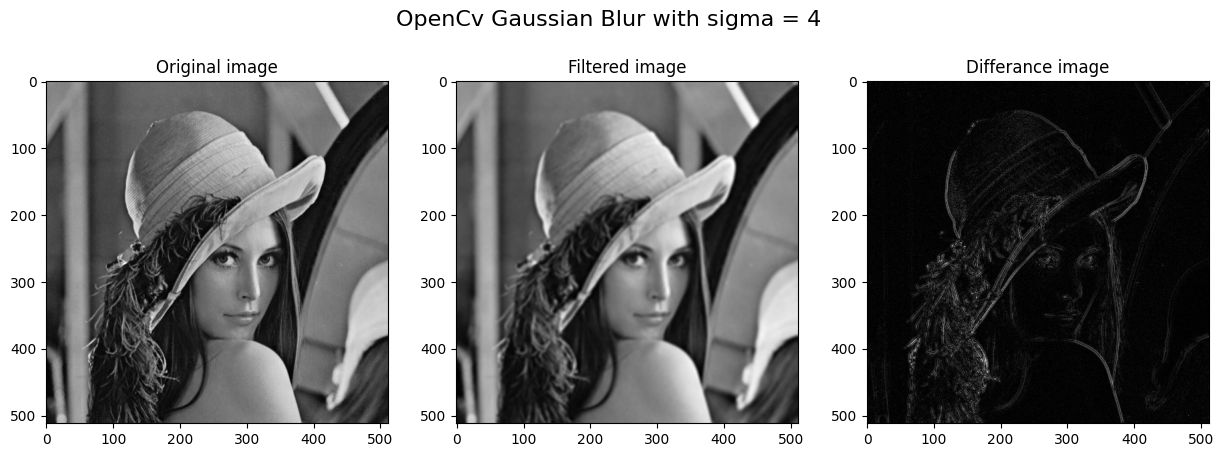

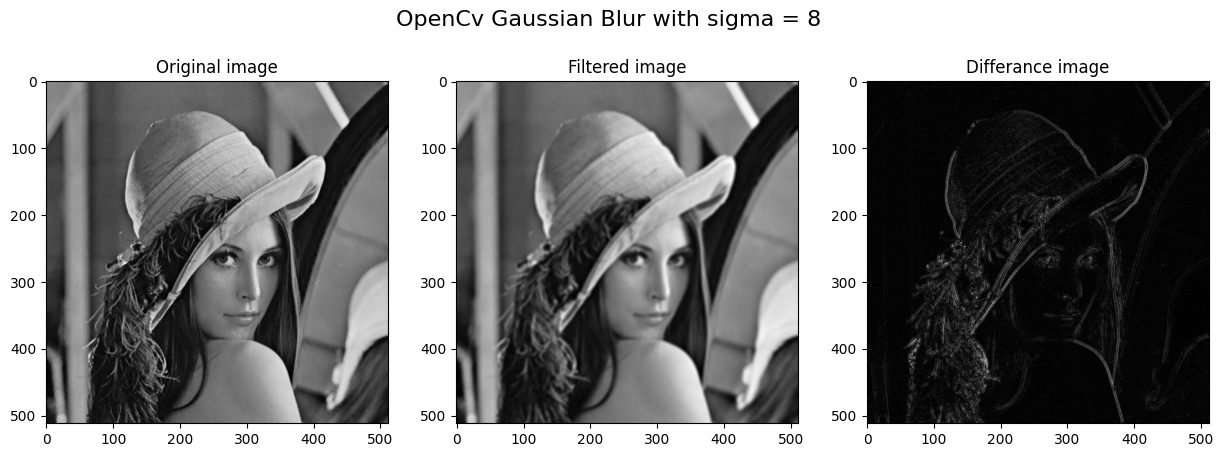

In [78]:
sigmas = [0.3, 4, 8]

for s in sigmas:
    filtered_lena = cv2.GaussianBlur(src=lena_img, ksize=(5, 5), sigmaX=s)
    differ_lena = cv2.absdiff(lena_img, filtered_lena)
    
    plot_images(original_img=lena_img, result_img=filtered_lena, diff_img=differ_lena, title=f'OpenCv Gaussian Blur with sigma = {s}')
    

### Filtry nieliniowe -- mediana

Filtry rozmywające redukują szum, ale niekorzystnie wpływają na ostrość obrazu.
Dlatego często wykorzystuje się filtry nieliniowe - np. filtr medianowy (dla przypomnienia: mediana - środkowa wartość w posortowanym ciągu liczb).

Podstawowa różnica pomiędzy filtrami liniowymi, a nieliniowymi polega na tym, że przy filtracji liniowej na nową wartość piksela ma wpływ wartość wszystkich pikseli z otoczenia (np. uśrednianie, czasem ważone), natomiast w przypadku filtracji nieliniowej jako nowy piksel wybierana jest któraś z wartości otoczenia - według jakiegoś wskaźnika (wartość największa, najmniejsza czy właśnie mediana).


1. Wczytaj obraz _lenaSzum.png_ (losowe 10% pikseli białych lub czarnych - tzw. zakłócenia impulsowe). Przeprowadź filtrację uśredniającą z rozmiarem maski 3x3. Wyświetl, podobnie jak wcześniej, oryginał, wynik filtracji i moduł z różnicy. Wykorzystując funkcję ``cv2.medianBlur` wykonaj filtrację medianową _lenaSzum.png_ (z rozmiarem maski $3 \times 3$). Wyświetl, podobnie jak wcześniej, oryginał, wynik filtracji i moduł z różnicy. Która filtracja lepiej radzi sobie z tego typu szumem?

  Uwaga. Taki sam efekt da również użycie funkcji `signal.medfilt2d`.


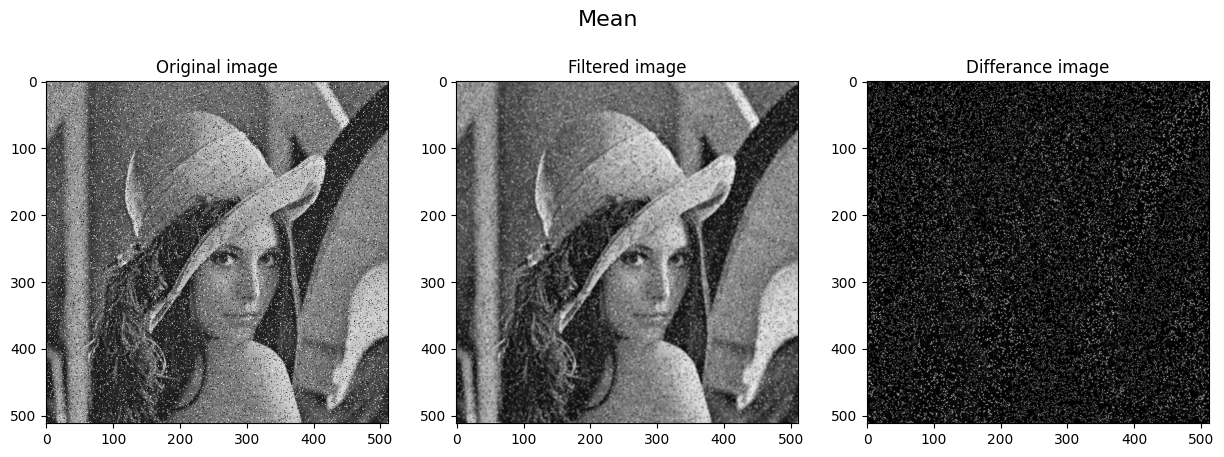

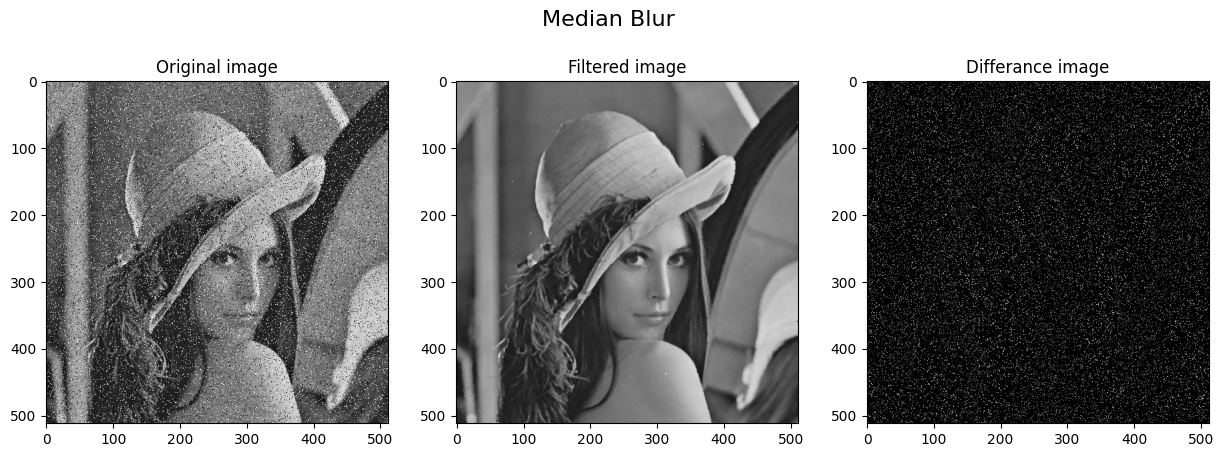

In [80]:
lena_noise = read_img('lenaSzum.png')

filtered_lena_noise_mean = apply_kernel(lena_noise, 3)
differ_lena_noise_mean =cv2.absdiff(lena_noise, filtered_lena_noise_mean)

filtered_lena_noise_blur = cv2.medianBlur(src=lena_noise, ksize=3)
differ_lena_noise_blur = cv2.absdiff(lena_noise, filtered_lena_noise_blur)


plot_images(original_img=lena_noise, result_img=filtered_lena_noise_mean, diff_img=differ_lena_noise_mean,title='Mean')

plot_images(original_img=lena_noise, result_img=filtered_lena_noise_blur, diff_img=differ_lena_noise_blur, title='Median Blur')

2. Przeprowadź filtrację uśredniającą, a następnie medianową obrazu _lena.png_.
   Wyniki porównaj - dla obu wyświetl: oryginał, wynik filtracji i moduł z różnicy.
   Szczególną uwagę zwróć na ostrość i krawędzie.
   W której filtracji krawędzie zostają lepiej zachowane?

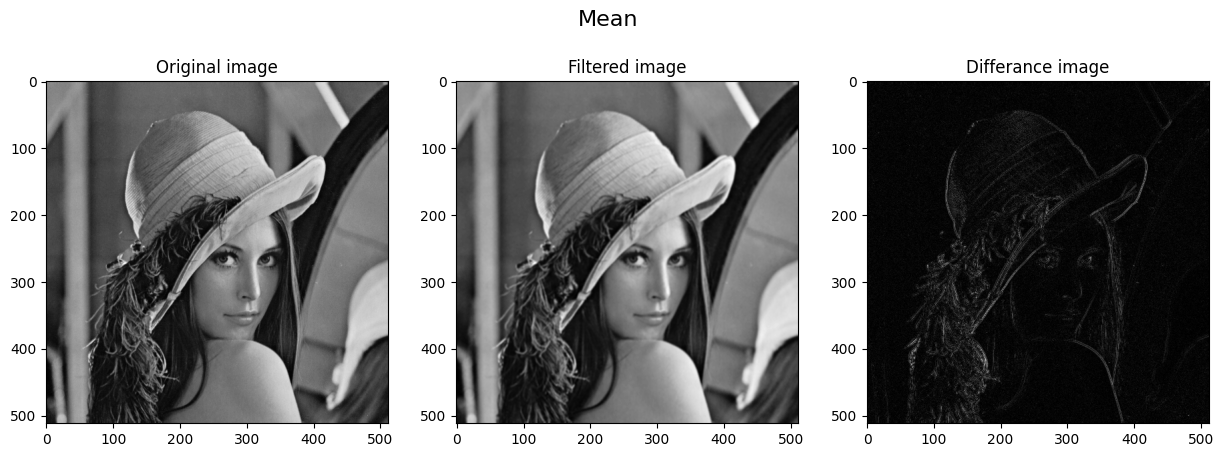

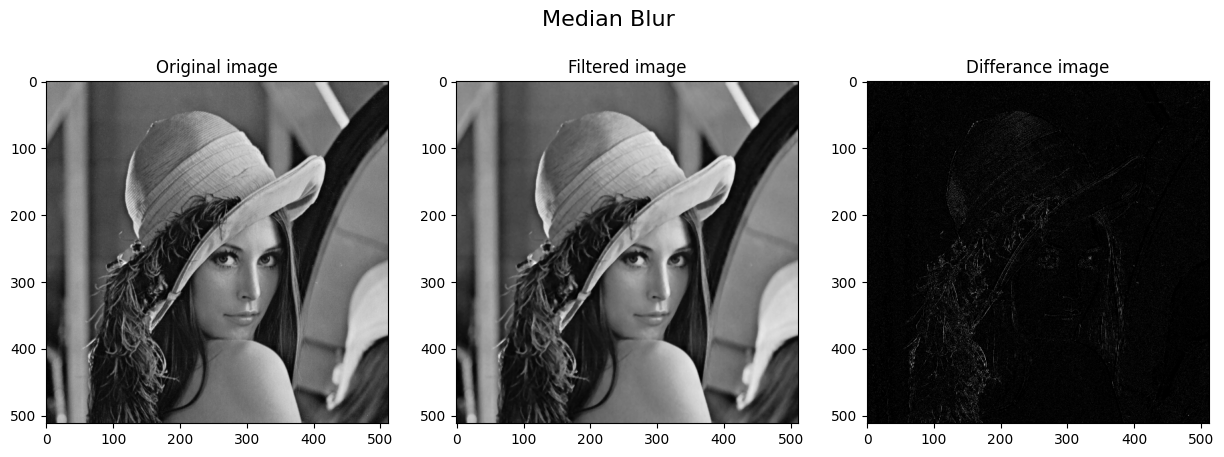

In [82]:
filtered_lena_mean = apply_kernel(lena_img, 3)
differ_lena_mean = cv2.absdiff(lena_img, filtered_lena_mean)

filtered_lena_blur = cv2.medianBlur(src=lena_img, ksize=3)
differ_lena_blur = cv2.absdiff(lena_img, filtered_lena_blur)


plot_images(original_img=lena_img, result_img=filtered_lena_mean, diff_img=differ_lena_mean, title='Mean')

plot_images(original_img=lena_img, result_img=filtered_lena_blur, diff_img=differ_lena_blur, title='Median Blur')

3. Ciekawy efekt można uzyskać wykonując filtrację medianową wielokrotnie. Określa się go mianem  posteryzacji.  W wyniku przetwarzania z obrazka usunięte zostają detale, a duże obszary uzyskują tą samą wartość jasności.  Wykonaj operację mediany $5 \times 5$ na obrazie _lena.png_ 10-krotnie. (wykorzystaj np. pętlę `for`).


Inne filtry nieliniowe:
- filtr modowy - moda (dominanta) zamiast mediany,
- filtr olimpijski - średnia z podzbioru otoczenia (bez wartości ekstremalnych),
- hybrydowy filtr medianowy - mediana obliczana osobno w różnych podzbiorach otoczenia (np. kształt ``x'',``+''), a jako wynik brana jest mediana ze zbioru wartość elementu centralnego, mediana z ``x'' i mediana z ``+'',
- filtr minimalny i maksymalny (będą omówione przy okazji operacji morfologicznych w dalszej części kursu).


Warto zdawać sobie sprawę, z szerokich możliwości dopasowywania rodzaju filtracji do konkretnego rozważanego problemu i rodzaju zaszumienia występującego na obrazie.

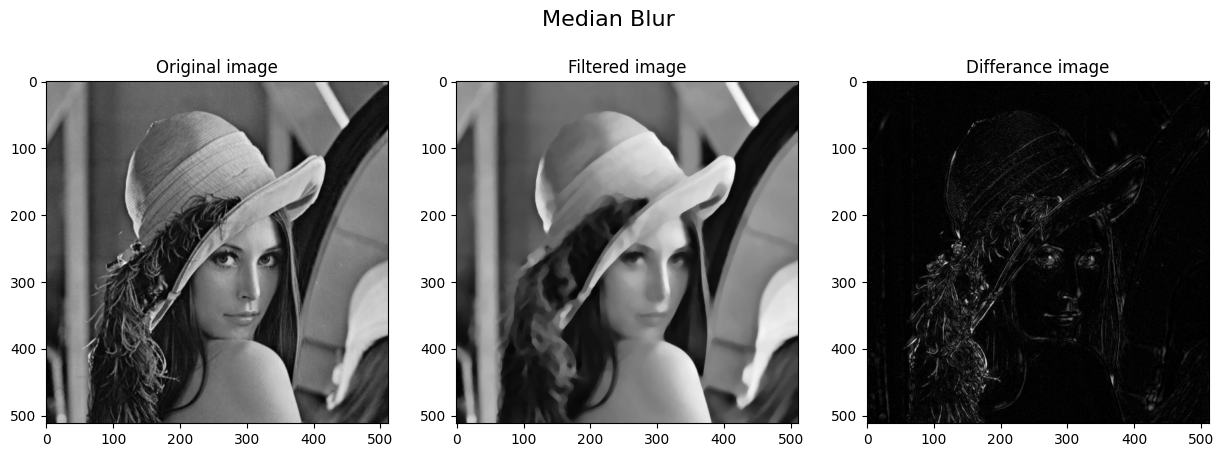

In [87]:
filtered_lena_blur = lena_img
for _ in range(10):
  
    filtered_lena_blur = cv2.medianBlur(src=filtered_lena_blur, ksize=5)


differ_lena_blur = cv2.absdiff(lena_img, filtered_lena_blur)
plot_images(original_img=lena_img, result_img=filtered_lena_blur, diff_img=differ_lena_blur, title='Median Blur')

## Filtry liniowe górnoprzepustowe (wyostrzające, wykrywające krawędzie)

Zadaniem filtrów górnoprzepustowych jest wydobywanie z obrazu składników odpowiedzialnych za szybkie zmiany jasności - konturów, krawędzi, drobnych elementów tekstury.

### Laplasjan (wykorzystanie drugiej pochodnej obrazu)

1. Wczytaj obraz _moon.png_.

2. Wprowadź podstawową maskę laplasjanu:
\begin{equation}
M = 
\begin{bmatrix}
0 & 1& 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0
\end{bmatrix}
\end{equation}

3. Przed rozpoczęciem obliczeń należy dokonać normalizacji maski - dla rozmiaru $3 \times 3$ podzielić każdy element przez 9.
   Proszę zwrócić uwagę, że nie można tu zastosować takiej samej normalizacji, jak dla filtrów dolnoprzepustowanych, gdyż skutkowałby to dzieleniem przez 0.

4. Wykonaj konwolucję obrazu z maską (`c2.filter2D`). Przed wyświetleniem, wynikowy obraz należy poddać normalizacji (występują ujemne wartości). Najczęściej wykonuje się jedną z dwóch operacji:
- skalowanie (np. poprzez dodatnie 128 do każdego z pikseli),
- moduł (wartość bezwzględna).

Wykonaj obie normalizacje. 
Na wspólnym wykresie wyświetl obraz oryginalny oraz przefiltrowany po obu normalizacjach. 

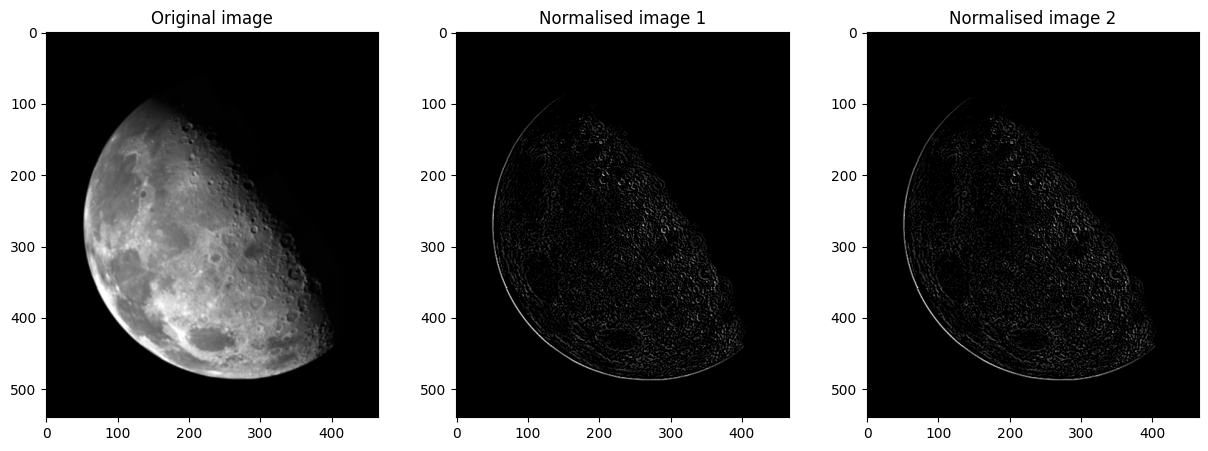

In [119]:
moon_img = read_img('moon.png')
mask = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
], dtype=np.float64)


mask /= 9


filtered_moon = cv2.filter2D(src=moon_img, ddepth=-1, kernel=mask)


def normalised_img(img):
    return img + 128, np.abs(img)



def plot_with_normalisation(img, norm_img_1, norm_img_2, title=''):

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))     
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(norm_img_1, cmap='gray')
    ax[2].imshow(norm_img_2, cmap='gray')
    ax[0].set_title('Original image')
    ax[1].set_title('Normalised image 1')
    ax[2].set_title('Normalised image 2')
    plt.show()
    
    
normalised_filtered_moon_1, normalised_filtered_moon_2 = normalised_img(filtered_moon)
plot_with_normalisation(moon_img, normalised_filtered_moon_1, normalised_filtered_moon_2)


7. Efekt wyostrzenia uzyskuje się po odjęciu/dodaniu (zależy do maski) rezultatu filtracji laplasjanowej i oryginalnego obrazu. Wyświetl na jednym wykresie: obraz oryginalny, sumę oryginału i wyniku filtracji oraz różnicę (bezwzględną) oryginału i wyniku filtracji.
 Uwaga. Aby uniknąć artefaktów, należy obraz wejściowy przekonwertować do formatu ze znakiem.



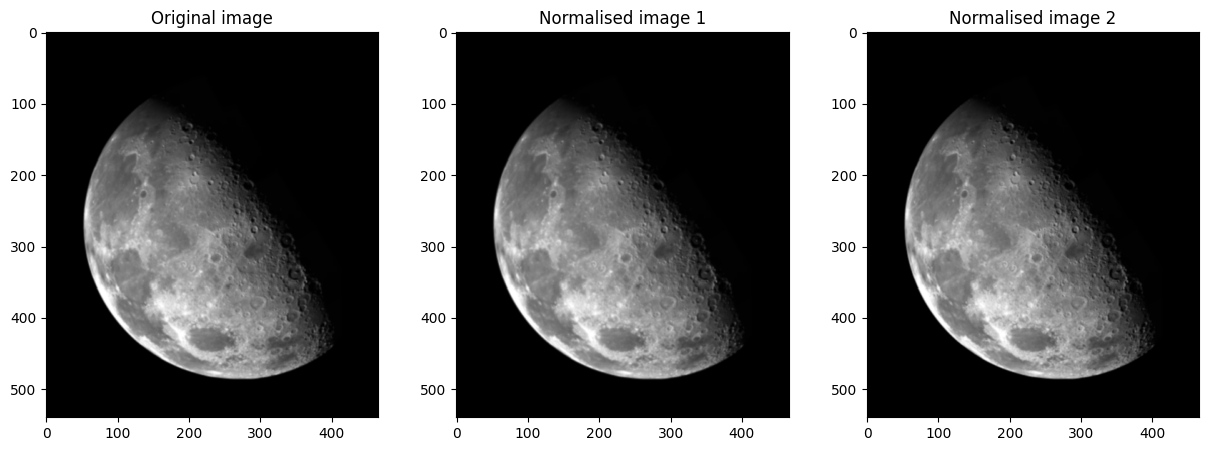

In [116]:

moon_img = moon_img.astype('uint8')

sum_moon_img = moon_img + normalised_filtered_moon_2
abs_moon_img = cv2.absdiff(moon_img, normalised_filtered_moon_2)

plot_with_normalisation(moon_img, sum_moon_img, abs_moon_img)

### Gradienty (wykorzystanie pierwszej pochodnej obrazu)

1. Wczytaj obraz _kw.png_. Stwórz odpowiednie maski opisane w kolejnych punktach i dokonaj filtracji.
2. Wykorzystując gradient Robertsa przeprowadź detekcję krawędzi - poprzez wykonanie konwolucji obrazu z daną maską:
\begin{equation}
R1 = \begin{bmatrix} 0 & 0 & 0 \\ -1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}   
R2 = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & -1 \\ 0 & 1 & 0 \end{bmatrix}
\end{equation}

Wykorzystaj stworzony wcześniej kod (przy laplasjanie) - dwie metody normalizacji oraz sposób wyświetlania.

3. Analogicznie przeprowadź detekcję krawędzi za pomocą gradientu Prewitta (pionowy i poziomy)
\begin{equation}
P1 = \begin{bmatrix} -1 & 0 & 1 \\ -1 & 0 & 1 \\ -1 & 0 & 1 \end{bmatrix}   
P2 = \begin{bmatrix} -1 & -1 & -1 \\ 0 & 0 & 0 \\ 1 & 1 & 1 \end{bmatrix}
\end{equation}

4. Podobnie skonstruowany jest gradient Sobela (występuje osiem masek, zaprezentowane są dwie ``prostopadłe''):
\begin{equation}
S1 = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}   
S2 = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
\end{equation}

Przeprowadź detekcję krawędzi za pomocą gradientu Sobela. 

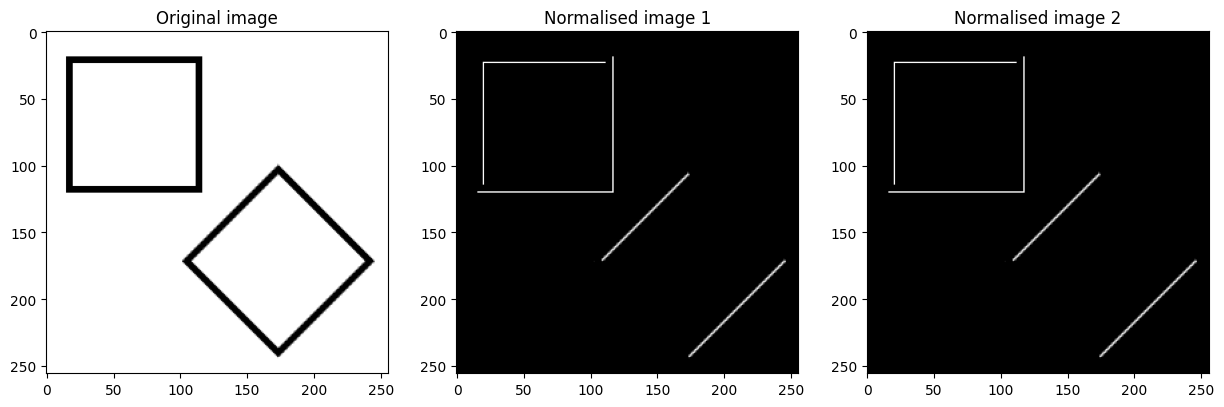

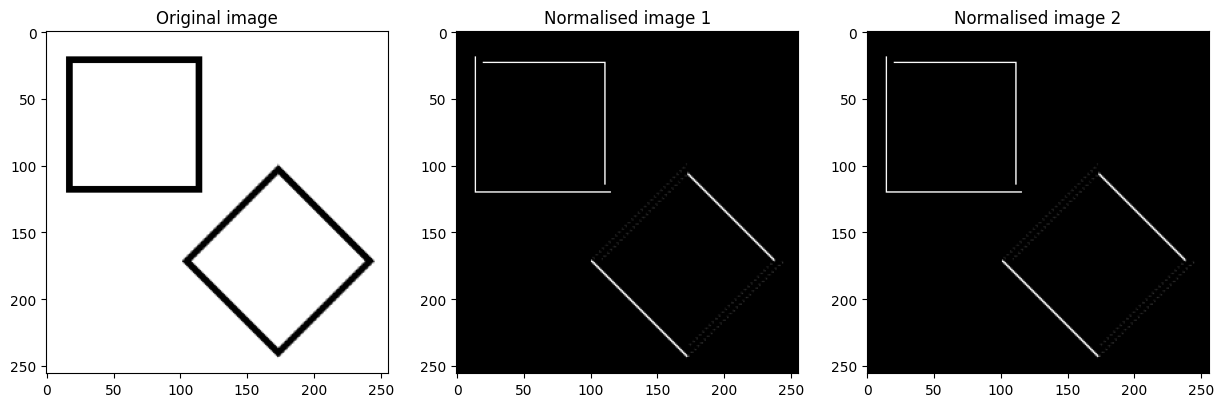

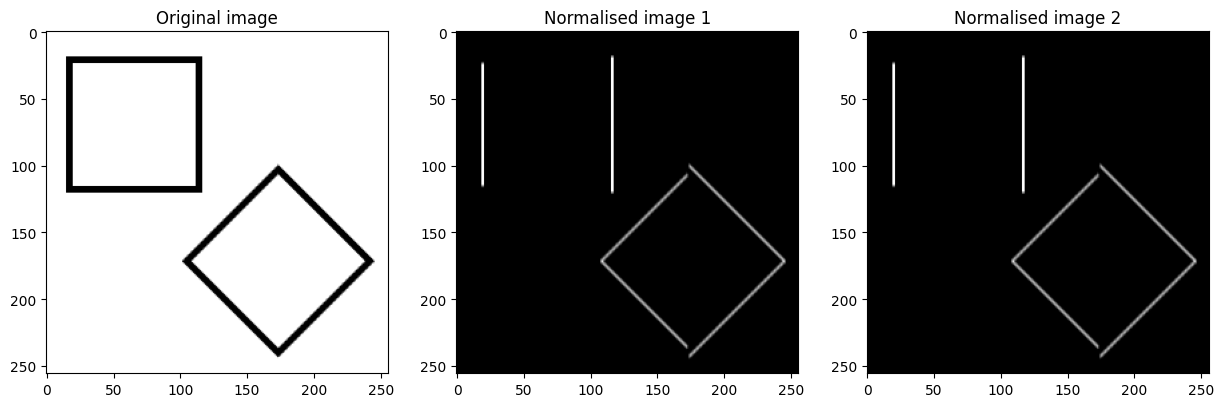

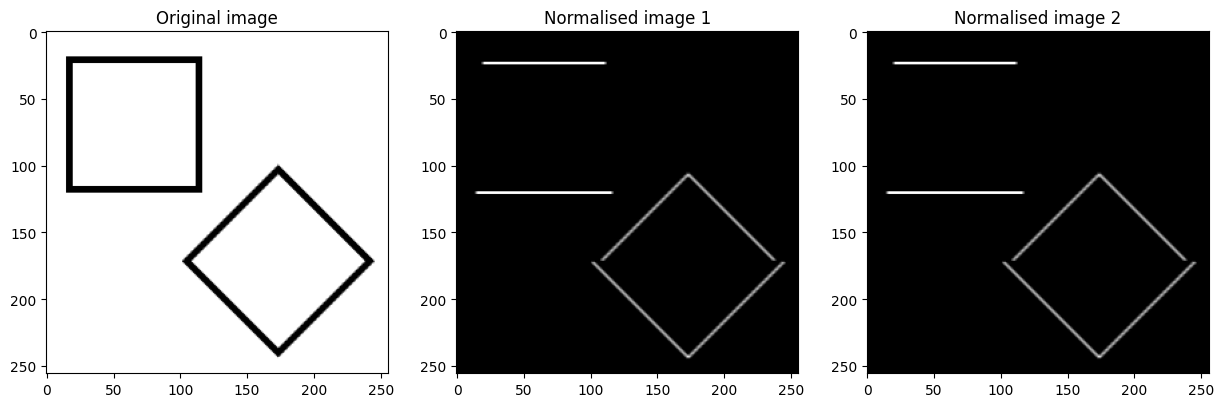

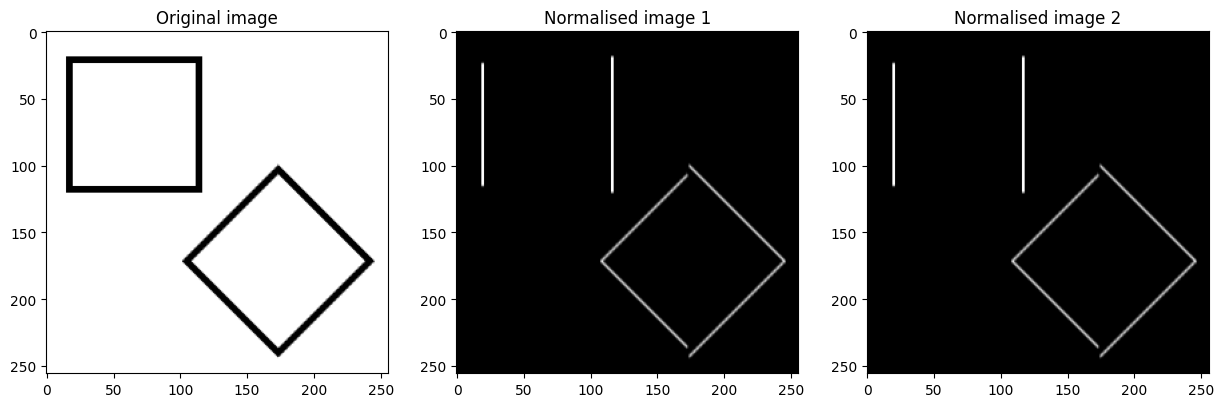

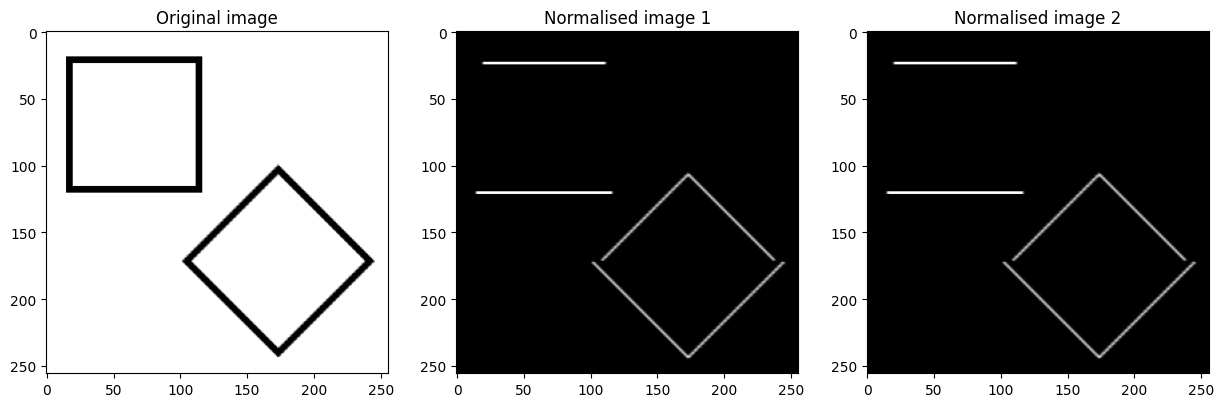

In [134]:
def show_gradient(img, gradient, title):
    img_filtered = cv2.filter2D(src=img, ddepth=-1, kernel=gradient)

    normalised_filtered_img_1 = np.clip(img_filtered + 128, 0, 255).astype(np.uint8)
    normalised_filtered_img_2 = np.clip(np.abs(img_filtered), 0, 255).astype(np.uint8)

    plot_with_normalisation(img, normalised_filtered_img_1,normalised_filtered_img_2, title)


kw_img = read_img('kw.png')

r1 = np.array([
    [0, 0, 0],
    [-1, 0, 0],
    [0, 1, 0]  
]) / 9

r2 = np.array([
    [0, 0, 0],
    [0, 0, -1],
    [0, 1, 0]  
]) / 9

p1 = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]  
]) / 9

p2 = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]  
]) / 9


s1 = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]  
]) / 9

s2 = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]  
]) / 9


show_gradient(kw_img, r1,title="Robert's gradient")
show_gradient(kw_img, r2,title="Robert's gradient")

show_gradient(kw_img, p1,title="Prewitt's gradient")
show_gradient(kw_img, p2,title="Prewitt's gradient")

show_gradient(kw_img, s1,title="Sobel's gradient")
show_gradient(kw_img, s2,title="Sobel's gradient")



5. Na podstawie dwóch ortogonalnych masek np. Sobela można stworzyć tzw. filtr kombinowany - pierwiastek kwadratowy z sumy kwadratów gradientów:
\begin{equation}
OW = \sqrt{(O * S1)^2 + (O * S2)^2}
\end{equation}
gdzie:  $OW$ - obraz wyjściowy, $O$ - obraz oryginalny (wejściowy), $S1,S2$ - maski Sobela, $*$ - operacja konwolucji.

Zaimplementuj filtr kombinowany.

Uwaga. Proszę zwrócić uwagę na konieczność zmiany formatu danych obrazu wejściowego - na typ znakiem



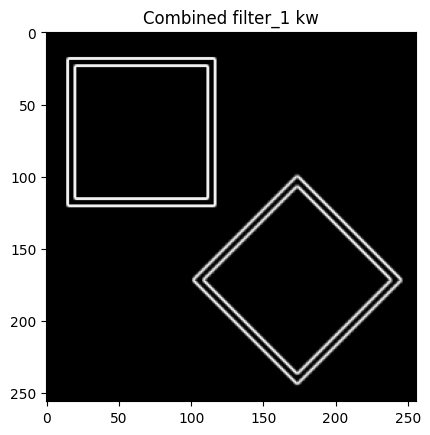

Text(0.5, 1.0, 'Combined filter_2 kw')

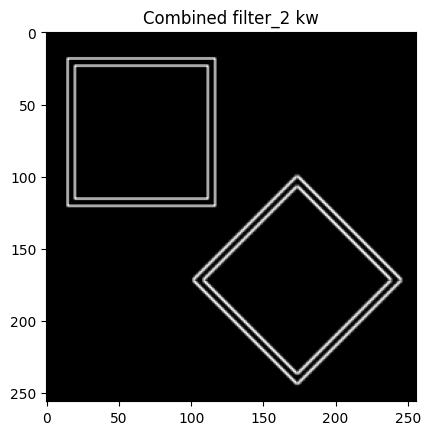

In [155]:
input_img = kw_img.astype('int16')

dst1 = cv2.filter2D(input_img, -1, s1)
dst2 = cv2.filter2D(input_img, -1, s2)
combine_filter_1 = np.sqrt(dst1**2+dst2**2)
combine_filter_2 = np.abs(dst1)+np.abs(dst2)


plt.imshow(combine_filter_1, cmap='gray')
plt.title('Combined filter_1 kw')
plt.show()
plt.imshow(combine_filter_2, cmap='gray')
plt.title('Combined filter_2 kw')

6. Istnieje alternatywna wersja filtra kombinowanego, która zamiast pierwiastka z sumy kwadratów wykorzystuje sumę modułów (prostsze obliczenia). 
Zaimplementuj tę wersję. 

7. Wczytaj plik _jet.png_ (zamiast _kw.png_).
Sprawdź działanie obu wariantów filtracji kombinowanej.

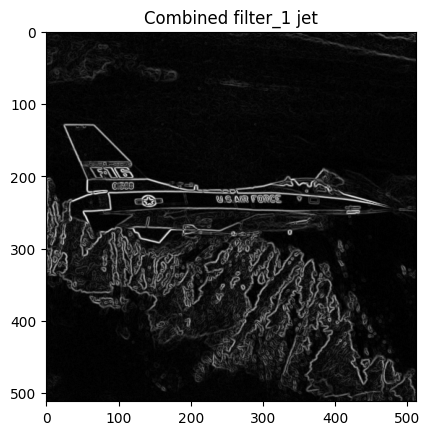

Text(0.5, 1.0, 'Combined filter_2 jet')

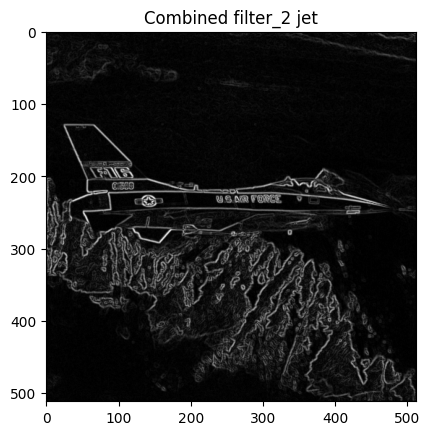

In [159]:
jet_img = read_img('jet.png').astype('int16')
dst1 = cv2.filter2D(jet_img, -1, s1)
dst2 = cv2.filter2D(jet_img, -1, s2)
combine_filter_1 = np.sqrt(dst1**2+dst2**2)
combine_filter_2 = np.abs(dst1)+np.abs(dst2)

plt.imshow(combine_filter_1, cmap='gray')
plt.title('Combined filter_1 jet')
plt.show()
plt.imshow(combine_filter_2, cmap='gray')
plt.title('Combined filter_2 jet')
